In [120]:
# Read Data
import numpy as np
import pandas as pd


In [121]:
%run ../src/campus_src.py


In [122]:
df = pd.read_csv("../data/processed/campus_processed.csv")
df = df.set_index("DateTime")

## Create Dataset

In [123]:
# 假設 df_encoded 是你的 DataFrame，且已經按時間順序排序
n_steps = 8  # 例如，使用t以及前面5步作為特徵

X, y = create_dataset(df.to_numpy(), n_steps)

print(y)
print(X.shape)
print(y.shape)

[ 84.352362  54.736467  28.047113 ...  73.581269 156.333926 222.44631 ]
(4311, 8, 35)
(4311,)


## Split

In [124]:
X_train, X_validation, X_test, y_train, y_validation, y_test = split_dataset(X, y, train_ratio=0.75, validation_ratio=0.15)

## Attack

In [108]:
def attack_all_add_pct(X, step_idx=7, feat_idx=1, pct=0.05):
    """
    对 X 中所有样本，在指定的 step_idx 和 feat_idx 位置，
    将原值增加 pct * 原值（即乘以 1+pct）。

    参数：
        X (np.ndarray): 待“攻击”的三维数组，shape=(n_samples, n_steps, n_features)
        step_idx (int): 时间步的索引，比如第8步就传 7
        feat_idx (int): 特征的索引，比如第2个特征就传 1
        pct (float): 增加比例，默认 0.05（5%）

    返回：
        np.ndarray: 攻击后的数组副本
    """
    X_attacked = X.copy()
    X_attacked[:, step_idx, feat_idx] *= (1 + pct)
    return X_attacked

X_test_attacked = attack_all_add_pct(X_test, step_idx=7, feat_idx=1, pct=0.2)
#X_test_attacked = attack_all_add_pct(X_test_attacked, step_idx=7, feat_idx=2, pct=0.2)

X_test = X_test_attacked.copy()

## Scaler

In [125]:
X_train, X_validation, X_test = scaling(X_train, X_validation, X_test, 3)

## =====================

## Model

In [126]:
"""
for i in range(len(X_train)): #每個X_train
  # 应用噪声
  X_train[i] = add_noise(X_train[i], noise_level=0.05)
"""

'\nfor i in range(len(X_train)): #每個X_train\n  # 应用噪声\n  X_train[i] = add_noise(X_train[i], noise_level=0.05)\n'

In [127]:
model = build_model_double_TCN(n_steps, X_train.shape[2])

/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_12 (TCN)                    │ (None, 8, 64)          │        97,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_13 (TCN)                    │ (None, 64)             │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,009 (793.00 KB)

 Trainable params: 203,009 (793.00 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_validation = np.array(X_validation, dtype=np.float32)
y_validation = np.array(y_validation, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [204]:
def fgsm_inject_one_pos(model, X_np, y_np, epsilon, step_idx=7, feat_idx=1):
    X_adv = X_np.astype(np.float32).copy()
    y_tf  = tf.convert_to_tensor(y_np, dtype=tf.float32)
    X_var = tf.Variable(X_adv)
    loss_fn = tf.keras.losses.MeanSquaredError()

    with tf.GradientTape() as tape:
        tape.watch(X_var)
        preds = model(X_var, training=False)
        preds = tf.reshape(preds, y_tf.shape)
        loss  = loss_fn(y_tf, preds)

    grad = tape.gradient(loss, X_var).numpy()         # (N, S, F)
    grad_sign = np.sign(grad)
    grad_sign[grad_sign < 0] = 0

    # ===== 插入调试打印 =====
    mask = np.zeros_like(grad_sign)
    mask[:, step_idx, feat_idx] = 1.0
    diff = (epsilon * grad_sign * mask)[:, step_idx, feat_idx]
    # ========================

    X_adv += epsilon * (grad_sign * mask)
    return X_adv

def fgsm_inject_one_pos(model, X_np, y_np, epsilon, targeted=False, step_idx=None, feat_idx=None):
    X_adv = X_np.copy().astype(np.float32)
    y_tf = tf.convert_to_tensor(y_np, dtype=tf.float32)
    X_var = tf.Variable(X_adv)
    
    # 创建损失函数实例
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    with tf.GradientTape() as tape:
        tape.watch(X_var)
        preds = model(X_var, training=False)
        preds = tf.reshape(preds, y_tf.shape)
        
        # 使用损失函数实例计算损失
        loss = loss_fn(y_tf, preds)
        
        if targeted:  # 添加定向攻击支持
            loss = -loss

    grad = tape.gradient(loss, X_var).numpy()
    grad_sign = np.sign(grad)
    grad_sign[grad_sign < 0] = 0  # 负梯度归零（与原始逻辑一致）

    # 应用扰动
    if step_idx is not None and feat_idx is not None:
        # 定点扰动模式
        mask = np.zeros_like(grad_sign)
        mask[:, step_idx, feat_idx] = 1.0
        X_adv += epsilon * (grad_sign * mask)
    else:
        # 全局扰动模式
        X_adv += epsilon * grad_sign

    return X_adv


# 全局擾動只擾動前三個特徵
def fgsm_inject_one_pos(model, X_np, y_np, epsilon, targeted=False, step_idx=None, feat_idx=None):
    X_adv = X_np.copy().astype(np.float32)
    y_tf = tf.convert_to_tensor(y_np, dtype=tf.float32)
    X_var = tf.Variable(X_adv)
    
    # 创建损失函数实例
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    with tf.GradientTape() as tape:
        tape.watch(X_var)
        preds = model(X_var, training=False)
        preds = tf.reshape(preds, y_tf.shape)
        
        # 使用损失函数实例计算损失
        loss = loss_fn(y_tf, preds)
        
        if targeted:  # 添加定向攻击支持
            loss = -loss

    grad = tape.gradient(loss, X_var).numpy()
    grad_sign = np.sign(grad)
    grad_sign[grad_sign < 0] = 0  # 负梯度归零（与原始逻辑一致）
    
    # === 新增：创建特征掩码（只允许修改前3个特征） ===
    # 假设输入形状为 (batch, time_steps, features)
    feature_mask = np.zeros(X_adv.shape[-1])  # 特征维度的掩码
    feature_mask[:3] = 1.0  # 只允许修改前3个特征
    
    # 应用扰动
    if step_idx is not None and feat_idx is not None:
        # 定点扰动模式：只修改特定位置
        mask = np.zeros_like(grad_sign)
        mask[:, step_idx, feat_idx] = 1.0
        X_adv += epsilon * (grad_sign * mask)
    else:
        # 全局扰动模式：只修改前3个特征
        # 将特征掩码广播到整个张量
        broadcast_mask = np.zeros_like(X_adv)
        broadcast_mask[..., :3] = 1.0  # 所有批次和时间步的前3个特征
        
        # 应用扰动时只修改允许的特征
        X_adv += epsilon * (grad_sign * broadcast_mask)

    return X_adv

#定点扰动（您原始的需求）：
# adv_x = fgsm_inject_one_pos(
#     model, 
#     X, 
#     y, 
#     epsilon=0.1,
#     step_idx=7, 
#     feat_idx=1
# )
# #全局扰动（与原始FGSM相同）：
# adv_x = fgsm_inject_one_pos(
#     model, 
#     X, 
#     y, 
#     epsilon=0.1
#     # 不指定step_idx和feat_idx
# )

#想让它都预测成原来的两倍，就写 target_labels = y_test * 2.0
#定向攻击：

# adv_x = fgsm_inject_one_pos(
#     model, 
#     X, 
#     target_y,  # 传入目标标签
#     epsilon=0.1,
#     targeted=True
# )
 
# targeted 支持你选择是做普通的 untargeted 式白帽攻击（最大化正确标签损失），还是做针对某个目标标签的 targeted 攻击（最小化目标标签损失）。


# —— 使用示例 —— #
epsilon = 0.2
# 假设 X_test, y_test 已准备好
target_y = y_test*2.2
X_test_adv = fgsm_inject_one_pos(model, X_test, y_test, epsilon, targeted=True)#step_idx=7, feat_idx=1)

In [205]:
preds_clean = model.predict(X_test)
preds_adv   = model.predict(X_test_adv)    # 一定要传 X_test_adv
print("max abs diff:", np.max(np.abs(preds_adv - preds_clean)))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
max abs diff: 32.526672


In [173]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping]  # 加入早期停止回調函數
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 15.8659 - val_loss: 15.1479
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 13.9723 - val_loss: 12.6506
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 15.5178 - val_loss: 12.2092
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 15.5683 - val_loss: 12.4695
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 13.5858 - val_loss: 11.9429
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 13.4324 - val_loss: 11.7622
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 13.0205 - val_loss: 12.8357
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 13.3997 - val_loss: 23.9021
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 17.0384 - val_loss: 13.0700
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 13.7356 - val_loss: 13.1249
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 18.5805 - val_loss: 16.5987
Epoch 12/100
26/26 ━━━━━━━━━━━

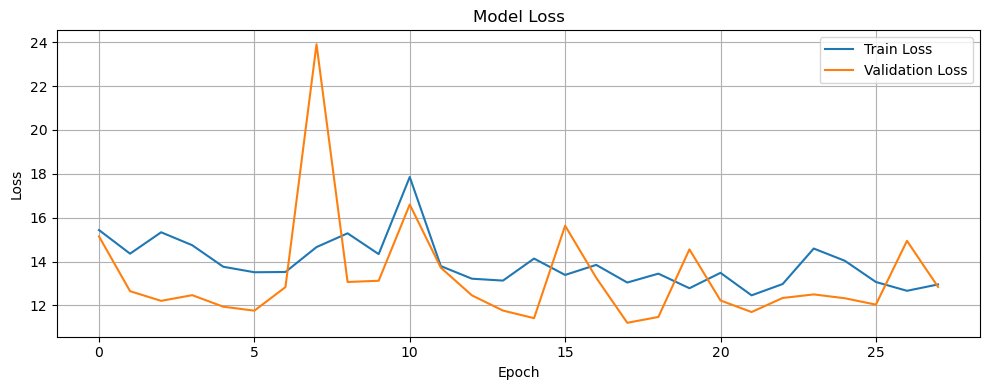

In [193]:
plot_loss(history)

Testing Length: 432
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


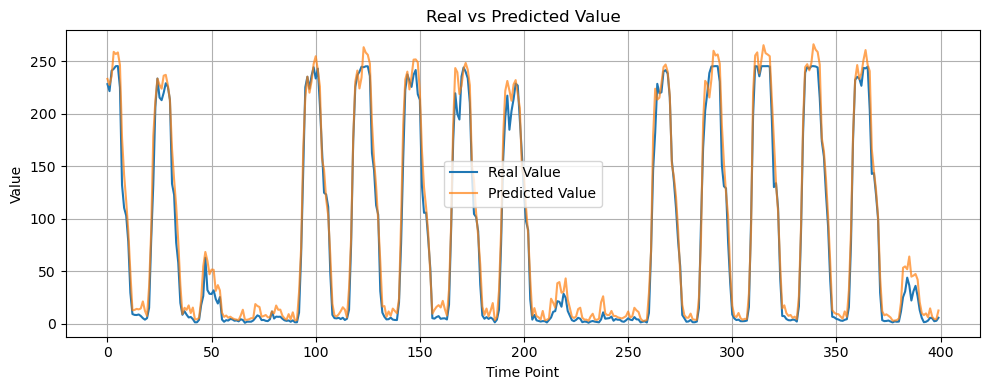

In [198]:
plot_predictions(model, X_test_adv, y_test, start=0, end=400)

Testing Length: 432
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


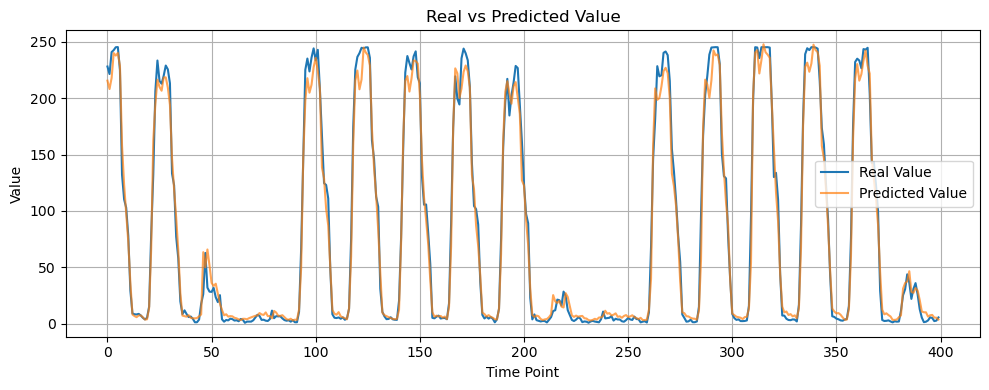

In [196]:
plot_predictions(model, X_test, y_test, start=0, end=400)

In [197]:
predicted = model.predict(X_test_adv).reshape(-1, 1)
results = evaluate_regression(y_test, predicted)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Absolute Error: 9.294327735900879
Mean Squared Error: 160.17454528808594
Root Mean Squared Error: 12.65600826833192
R^2 Score: 0.9816021919250488
Mean Absolute Percentage Error: 0.7928752899169922


In [ ]:
import os
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# 定義一個函式，強制從 _1 開始依序編號檔名
def get_unique_filename(filename):
    """
    不論檔案是否存在，皆從 _1 開始附加到檔名上，
    若有同樣編號的檔案存在，則依序累加編號，直到找到尚不存在的檔名。
    """
    base, ext = os.path.splitext(filename)
    i = 1
    unique_filename = f"{base}_{i}{ext}"
    while os.path.exists(unique_filename):
        i += 1
        unique_filename = f"{base}_{i}{ext}"
    return unique_filename

# ------------------------
# 對測試集進行預測及計算指標
# ------------------------

# 進行測試集預測並轉換成一維陣列
predicted_test = model.predict(X_test).reshape(-1, 1)

# 計算各項回歸評估指標
mse = mean_squared_error(y_test, predicted_test)
mae = mean_absolute_error(y_test, predicted_test)
rmse = sqrt(mse)
r2 = r2_score(y_test, predicted_test)
mape = mean_absolute_percentage_error(y_test, predicted_test)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f'MAPE: {mape}')

# 將測試集真值與預測結果合併成 DataFrame
test_results = pd.DataFrame({
    'True': y_test.flatten(),
    'Predicted': predicted_test.flatten()
})

# 取得唯一檔名並儲存測試集結果成 CSV 檔案
test_csv_filename = get_unique_filename('test_predictions.csv')
test_results.to_csv(test_csv_filename, index=False)
print(f"測試集結果儲存到檔案: {test_csv_filename}")

# ------------------------
# 對訓練集進行預測並儲存結果
# ------------------------

# 預測訓練集資料
predicted_train = model.predict(X_train).reshape(-1, 1)

# 將訓練集真值與預測結果合併成 DataFrame
train_results = pd.DataFrame({
    'True': y_train.flatten(),
    'Predicted': predicted_train.flatten()
})

# 取得唯一檔名並儲存訓練集結果成 CSV 檔案
train_csv_filename = get_unique_filename('train_predictions.csv')
train_results.to_csv(train_csv_filename, index=False)
print(f"訓練集結果儲存到檔案: {train_csv_filename}")

# 結果分析

## 每小時誤差

In [ ]:
for index, row in df_extraction.iterrows():
  for i in range(len(y_test)):
    if (row["value_avg"]/1000000) == y_test[i]:
      df_extraction.loc[index, "predicted"] = predicted[i][0]

In [ ]:
df_extraction_hour = df_extraction.dropna()

In [ ]:
df_extraction_hour["value_avg"] = df_extraction_hour["value_avg"] / 1000000

In [ ]:
df_extraction_hour

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["hour"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(24)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each hour')
plt.xticks(hours)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["weekday"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(7)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each weekday')
plt.xticks(hours)
plt.legend()
plt.show()